# 20 news group experiments

---

In this lab work, we want to proceed the cosine separation but on a task with many labels.
The objective is to see if the model, can separate many classes in the latent space.

In [1]:
%load_ext autoreload
%autoreload 2
import torch

import os
from os import path
import sys
from rich import print
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
cwd = os.getcwd().split(os.path.sep)

# point to the git repository
while cwd[-1] != "AttentionGeometry":
    os.chdir("..")
    cwd = os.getcwd().split(os.path.sep)

# add the root directory
sys.path.append(os.path.join(os.getcwd(), "src"))

# cache and data cache
cache_path = path.join(os.getcwd() ,'.cache_bert')
dataset_path = path.join(cache_path, 'dataset')
log_path = path.join(cache_path, 'logs')
model_path = path.join(cache_path, 'models')
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load the data

In [2]:
from datasets import load_dataset
dataset = load_dataset("SetFit/20_newsgroups", split='test')

Using custom data configuration SetFit--20_newsgroups-a753b4a7bacd71a8
Reusing dataset json (C:\Users\loicf\.cache\huggingface\datasets\SetFit___json\SetFit--20_newsgroups-a753b4a7bacd71a8\0.0.0\ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b)


In [3]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

In [4]:
def tokenize_function(data):
    return tokenizer(data["text"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
n = len(tokenized_datasets)
labels = list(set(dataset["label"]))

Loading cached processed dataset at C:\Users\loicf\.cache\huggingface\datasets\SetFit___json\SetFit--20_newsgroups-a753b4a7bacd71a8\0.0.0\ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b\cache-a102a78b656fd3ef.arrow


## Load the model

In [5]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    os.path.join(log_path, "20-news-groups"),
    num_labels=20,
    output_hidden_states=True
)
model = model.eval()

## Evaluation of the model, class by class

In [6]:
acc_by_class = {l : [] for l in labels}

with torch.no_grad():
    model = model.to(DEVICE)
    for i in tqdm(range(n), total=n):
        ex = tokenized_datasets[i]
        label = tokenized_datasets[i]["label"]
        ids = torch.tensor(ex["input_ids"]).unsqueeze(0)
        att_mask = attention_mask=torch.tensor(ex["attention_mask"]).unsqueeze(0)
        output_model = model(
            input_ids = ids.to(DEVICE), 
            attention_mask = att_mask.to(DEVICE)
        )
        pred = output_model.logits
        
        # add 1 if we predicted well the class
        acc_by_class[label].append((np.argmax(pred.cpu().numpy()) == label)*1)

acc_res = [0]*20
for l in acc_by_class:
    temp = np.array(acc_by_class[l]).mean()
    acc_res[l] = temp

  0%|          | 0/7532 [00:00<?, ?it/s]

## Get the embedding of each document in the test set

In [7]:
cls_embeddings = []
with torch.no_grad():
    model = model.to(DEVICE)
    for i in tqdm(range(n), total=n):
        ex = tokenized_datasets[i]
        label = tokenized_datasets[i]["label"]
        ids = torch.tensor(ex["input_ids"]).unsqueeze(0)
        att_mask = attention_mask=torch.tensor(ex["attention_mask"]).unsqueeze(0)
        output_model = model(
            input_ids = ids.to(DEVICE), 
            attention_mask = att_mask.to(DEVICE)
        )

        temp = {
            "embedding" : output_model.hidden_states[-1][0, 0, :].cpu(),
            "label": label
        }
        cls_embeddings.append(temp)

  0%|          | 0/7532 [00:00<?, ?it/s]

## For each class : get the representative $r_i$

In [8]:
rep = {l : None for l in labels}

In [9]:
with torch.no_grad():
    for l in labels:
        for i in range(len(tokenized_datasets)):
            ex = tokenized_datasets[i]
            label = tokenized_datasets[i]["label"]
            ids = torch.tensor(ex["input_ids"]).unsqueeze(0)
            att_mask = attention_mask=torch.tensor(ex["attention_mask"]).unsqueeze(0)
            output_model = model(
                input_ids = ids.to(DEVICE), 
                attention_mask = att_mask.to(DEVICE)
            )
            pred = output_model.logits        

            if label == l and np.argmax(pred.detach().cpu().numpy()) == l:
                print(f"representative for class {l} : found")
                rep[l] = dict()
                rep[l]["embedding"] = output_model.hidden_states[-1][0, 0, :].cpu()
                rep[l]["text"] = tokenized_datasets[i]["text"]
                rep[l]["rep-idx"] = i
                break

representative for class 0 : found

representative for class 1 : found

representative for class 2 : found

representative for class 3 : found

representative for class 4 : found

representative for class 5 : found

representative for class 6 : found

representative for class 7 : found

representative for class 8 : found

representative for class 9 : found

representative for class 10 : found

representative for class 11 : found

representative for class 12 : found

representative for class 13 : found

representative for class 14 : found

representative for class 15 : found

representative for class 16 : found

representative for class 17 : found

representative for class 18 : found

representative for class 19 : found

## Compute the cosines

In [10]:
final_res = {}

for l in rep:
    print(f"compute cosines for the representative {l}")
    
    rep_embedding = rep[l]["embedding"]
    rep_label = l
    rep_norm = torch.norm(rep_embedding)
    
    cos_values = []
    lab_values = []
    
    for cls in cls_embeddings:
        candidate_emb = cls["embedding"]
        candidate_class = cls["label"]
        candidate_norm = torch.norm(candidate_emb)
        
        scalar = torch.dot(rep_embedding, candidate_emb)
        cos_values.append((scalar / (candidate_norm * rep_norm)).item())
        lab_values.append(candidate_class)
    
    assert len(cos_values)==len(lab_values)
    final_res[l]={
        "cos_values": cos_values,
        "lab_values": lab_values,
    }
        

compute cosines for the representative 0

compute cosines for the representative 1

compute cosines for the representative 2

compute cosines for the representative 3

compute cosines for the representative 4

compute cosines for the representative 5

compute cosines for the representative 6

compute cosines for the representative 7

compute cosines for the representative 8

compute cosines for the representative 9

compute cosines for the representative 10

compute cosines for the representative 11

compute cosines for the representative 12

compute cosines for the representative 13

compute cosines for the representative 14

compute cosines for the representative 15

compute cosines for the representative 16

compute cosines for the representative 17

compute cosines for the representative 18

compute cosines for the representative 19

## Compute the different graphics

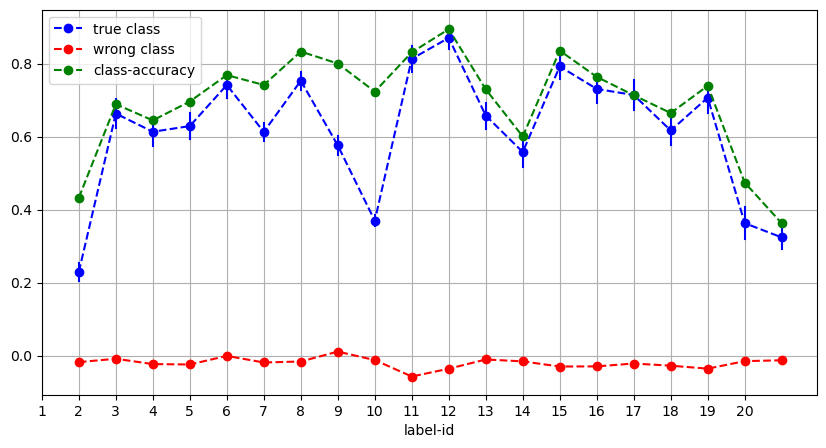

In [42]:
y1 = []
y2 = []
dev1 = []
dev2 = []
x = []

for l in final_res:
    cos_values = np.array(final_res[l]["cos_values"])
    temp = np.array(final_res[l]["lab_values"])
    mask = (temp==l)
    
    m1 = cos_values[mask].mean()
    s1 = 2 * cos_values[mask].std()/np.sqrt(len(cos_values[mask]))
    y1.append(m1)
    dev1.append(s1)
    
    m2 = cos_values[~mask].mean()
    s2 = 2 * cos_values[~mask].std()/np.sqrt(len(cos_values[~mask]))
    y2.append(m2)
    dev2.append(s2)
    
    x.append(l+1)

    
y1 = np.array(y1)
dev1 = np.array(dev1)
y2 = np.array(y2)
dev2 = np.array(dev2)

figure, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(x, y1, "o--", label="true class", color="blue")
ci_inf = y1-dev1
ci_sup = y1+dev1
for i, l in enumerate(x):
    ax.plot([l, l], [ci_inf[i], ci_sup[i]], color="blue")


ax.plot(x, y2, "o--", label="wrong class", color="red")
ci_inf = y2-dev2
ci_sup = y2+dev2
for i, l in enumerate(x):
    ax.plot([l, l], [ci_inf[i], ci_sup[i]], color="red")

ax.plot(x, acc_res, "o--", label="class-accuracy", color="green")
ax.legend()
ax.set_xticks(list(range(20)))
ax.set_xticklabels(list(range(1, 21)))
ax.grid()
temp = ax.set(
    xlabel="label-id"
)
plt.savefig(os.path.join(".cache_bert", "plots", "paper", "20-news-group.png"))

C:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\matplotlib\cbook\__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
C:\Users\loicf\miniconda3\envs\nlp\lib\site-packages\matplotlib\cbook\__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


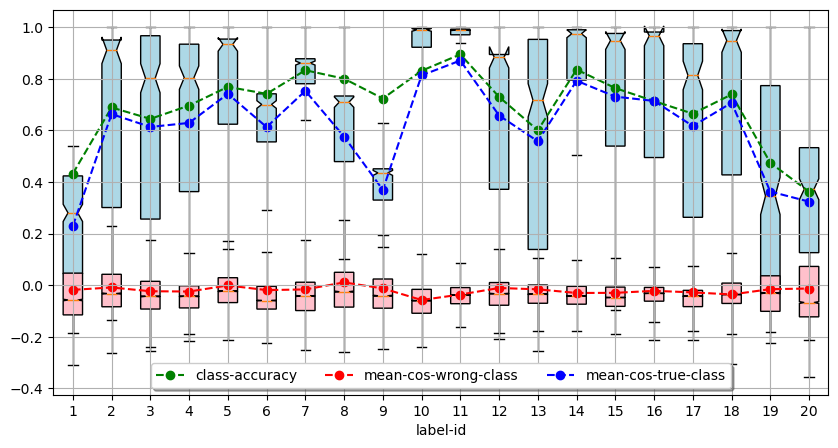

In [60]:
data1 = []
data2 = []

for l in final_res:
    cos_values = np.array(final_res[l]["cos_values"])
    temp = np.array(final_res[l]["lab_values"])
    mask = (temp==l)
    
    data1.append(cos_values[mask])
    data2.append(cos_values[~mask])

    
y1 = np.array(y1)
dev1 = np.array(dev1)
y2 = np.array(y2)
dev2 = np.array(dev2)

figure, ax = plt.subplots(1, 1, figsize=(10, 5))
bplot1 = ax.boxplot(data1, showfliers=False, patch_artist=True, notch=True, zorder=-1)
bplot2 = ax.boxplot(data2, showfliers=False, patch_artist=True, notch=True, zorder=-1)
for patch in bplot1['boxes']:
    patch.set_facecolor("lightblue")
    
for patch in bplot2['boxes']:
    patch.set_facecolor("pink")

ax.plot(x, acc_res, "o--", label="class-accuracy", color="green", zorder=1)
ax.plot(x, y2, "o--", label="mean-cos-wrong-class", color="red", zorder=1)
ax.plot(x, y1, "o--", label="mean-cos-true-class", color="blue", zorder=1)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.1),
          ncol=3, fancybox=True, shadow=True)
ax.set_xticks(list(range(1, 21)))
ax.set_xticklabels(list(range(1, 21)))
ax.grid()
temp = ax.set(
    xlabel="label-id"
)

plt.savefig(os.path.join(".cache_bert", "plots", "paper", "20-news-group.png"))

In [66]:
from scipy.stats import pearsonr, spearmanr
print(pearsonr(y1, acc_res))
print(spearmanr(y1, acc_res))

(0.8643237651460547, 8.948127903827096e-07)

SpearmanrResult(correlation=0.8075187969924811, pvalue=1.6726328546716402e-05)